# This is my machine learning project that predicts survival of Titanic passengers. My goal was to achive an accuracy of over 80% and this models has acuracy of 80.382 % which is top 6% of scores in Kaggle's competition.

# 1. Imports

In [69]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
#!pip install catboost
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

# Tensor flow
import tensorflow as tf
tf.__version__

'2.2.0'

In [70]:
# data download
df_train = pd.read_csv(r'C:\Users\giuse\Desktop\Titanic\train.csv')
df_test = pd.read_csv(r'C:\Users\giuse\Desktop\Titanic\test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Definitions

### Graphs

In [71]:
# ---------------------------------------------------
# Def Function for Graph for Feature Against Survival
# ---------------------------------------------------

def plot_cat_dist(data, feature, target, figsize=(20, 3)):
    unique_values = data[feature].nunique()
    if  unique_values < 25: 
        if unique_values < 10:
            figsize=(20, 3)
        else:
            figsize=(20,7)
            pass
            
        # dfn - new data frame with only target and feature in question
        dfn=pd.DataFrame()
        dfn=data[[target,feature]] 

        # dfn grouped
        df_by_category = pd.crosstab(dfn[target],dfn[feature])

        # get categories
        feature_categories = df_by_category.columns.values
        number_of_feature_categories = len(feature_categories)

        # dfo transposed
        dft = df_by_category.transpose()

        # adding totals and %
        dft['Tot']=dft[0]+dft[1]
        dft['Survival_rate']=round(dft[1]*100/dft['Tot'],(2))
        dft['Non_survival_rate']=round(dft[0]*100/dft['Tot'],(2))

        # values of counts by category
        survivors_counts = dft[1]
        non_survivors_counts = dft[0]

        # values of counts by category
        survivors_percentages = dft['Survival_rate']
        non_survivors_percentages = dft['Non_survival_rate']

        #graph    
        tick_list = np.linspace(0,len(feature_categories),len(feature_categories)+1)  
    
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        # plot chart for count of survivors by class
        ax1.barh(range(len(survivors_counts)), survivors_counts, label='Survivors', alpha=0.6, color='g')
        ax1.barh(range(len(non_survivors_counts)), non_survivors_counts, left=survivors_counts, label='Non-Survivors', alpha=0.6, color='r')
        plt.sca(ax1)
        plt.yticks(tick_list, feature_categories, fontsize=20)
        ax1.set_ylabel('')
        ax1.set_xlabel("Count", fontsize=20)
        ax1.set_title("Count of survivors by {}".format(feature),fontsize=20)
        plt.legend(loc='upper left')
      
        # plot chart for percentage of survivors by class
        ax2.barh(range(len(survivors_percentages)), survivors_percentages, alpha=0.7, color='g')
        ax2.barh(range(len(non_survivors_percentages)), non_survivors_percentages, left=survivors_percentages, alpha=0.1, color='r')
        plt.sca(ax2)
        plt.yticks(tick_list,  feature_categories, fontsize=20)
        ax2.set_ylabel('')
        ax2.set_xlabel("Percentage", fontsize=20)
        ax2.set_title("% of survivors by {}".format(feature),fontsize=20) 
    else:
        print("There are {} unique categories in feature {}".format(unique_values,feature))
        
def plot_continuous_as_discrete(data, label_size=30, xmin=0, xmax=10, ymin=0, ymax=10):
        
    # dfn - new data frame with only target and feature in question
    dfn=pd.DataFrame()
    dfn=data[[target,feature]] 

    # dfn grouped
    df_by_category = pd.crosstab(dfn[target],dfn[feature])

    # get categories
    feature_categories = df_by_category.columns.values
    number_of_feature_categories = len(feature_categories)

    # dfo transposed
    dft = df_by_category.transpose()

    # adding totals and %
    dft['Tot']=dft[0]+dft[1]
    dft['Survival_rate']=round(dft[1]*100/dft['Tot'],(2))
    dft['Non_survival_rate']=round(dft[0]*100/dft['Tot'],(2))

    # values of counts by category
    survivors_counts = dft[1]
    non_survivors_counts = dft[0]

    # values of counts by category
    survivors_percentages = dft['Survival_rate']
    non_survivors_percentages = dft['Non_survival_rate']

    # Defining main graph 
    
    fig = plt.figure()
    
    axes1 = fig.add_axes([0, 0, 5, 2])         # main axes  (left, bottom, width, height) 
    axes1.tick_params(labelsize=label_size)
    axes1.set_xlabel(feature,fontsize=label_size)
    axes1.set_ylabel('count',fontsize=label_size)
    axes1.set_title('{} vs {}'.format(feature,target),fontsize=label_size)
          
    green_patch = mpatches.Patch(color='g', label='Survived')
    red_patch = mpatches.Patch(color='r', label='Died')
    plt.legend(loc='upper left',handles=[green_patch,red_patch],fontsize=label_size)
    
    # Defining zoom
    axes2 = fig.add_axes([3.5, 1, 1.5, 1])
    axes2.tick_params(labelsize=label_size)
    axes2.set_xlim(xmin,xmax)
    axes2.set_ylim(ymin,ymax)
    axes2.set_title('zoom',fontsize=label_size)
                    
    # Defining plots    
    axes1.bar(survivors_counts.index, survivors_counts, label='Survivors',  color='g')
    axes1.bar(non_survivors_counts.index, non_survivors_counts, bottom=survivors_counts,  color='r')
    axes2.bar(survivors_counts.index, survivors_counts, label='Survivors',  color='g')
    axes2.bar(non_survivors_counts.index, non_survivors_counts, bottom=survivors_counts,  color='r') 
# ---------------------------------------------------
# Basic distribution plot for continuous data (float)
# ---------------------------------------------------  

def distribution_plot(data):
    plt.figure(figsize=(30,5))
    sns.set_color_codes()
    ax = sns.distplot(data[feature], color="b")
    ax.set_xlabel(feature,fontsize=30)
    ax.tick_params(labelsize=20)   
    
# ---------------------------------------------------
# Def Function for Countplot Graph 
# ---------------------------------------------------   

def simple_plot (data = df_train, figsize=(20,2)):
    plt.figure(figsize=figsize)
    colors = ["r", "g", "aqua", "blueviolet", "gold", "pink"]
    b= sns.countplot(y=feature, data=data, palette=colors)
    b.axes.set_title("Count of feature {}".format(feature),fontsize=40)
    b.set_xlabel("Count",fontsize=30)
    b.set_ylabel(feature,fontsize=30)
    b.tick_params(labelsize=20)

### Missing values

In [72]:
def find_missing_values(data,columns):
    missing_vals = {}   
    # df_length = len(dataframe)
    for column in columns:
        #total_column_values = dataframe[column].value_counts().sum()
        missing_vals[column] = len(data[column][data[column].isna()])
    return missing_vals

def missing_values(data):
    info = find_missing_values(data,columns = data.columns)
    return info

def miss_val_info():    
    missing_val = find_missing_values(df_train,columns = df_train.columns)
    print("The number of missing values in column {} for TRAIN set is".format(feature), + missing_val[feature])
    missing_valt = find_missing_values(df_test,columns = df_test.columns)
    print("The number of missing values in column {} for TEST set is".format(feature), + missing_valt[feature])


### Feature info

In [73]:
df_choice = pd.DataFrame()

def crosstab(data):
    return pd.crosstab(data[target],data[feature])

def show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True):
    unique_values = data[feature].nunique()
    if show_missing_values == True:        
        miss_val_info()
        print("The data type is", data[feature].dtype)
        print("_____________________________________________________________")   
    else:
        pass
    if show_other == True:
# cross tab
        if unique_values < 20:                    
            print(crosstab(data))
            print("_____________________________________________________________")
        else:
            pass
# probabilities    
        if unique_values < 10:
            print(data[[feature, target]].groupby([feature], as_index=False).mean().sort_values(by=target, ascending=False))
        else:
            pass
    else:
        pass
#graph
    if show_graph == True:
        try:
            plot_cat_dist(data, feature, target)
        except:
            simple_plot() 
    else: 
        pass
    
# Outlier detection 
def outliers_info(bounds_calculated_on=df_train, outlier_search_in=df_train): 
    
    # defining bounds
    global lower_bound, upper_bound
    mean = bounds_calculated_on[feature].mean()       
    std = bounds_calculated_on[feature].std()           
    lower_bound = mean - (3 * std)
    upper_bound = mean + (3 * std)
    
    # searching for outliers     
    index_list_lower = outlier_search_in[(outlier_search_in[feature] <  lower_bound)].index
    index_list_upper = outlier_search_in[(outlier_search_in[feature] >  upper_bound)].index
    how_many_outliers_in_lower = len(index_list_lower)
    how_many_outliers_in_upper = len(index_list_upper)
    
    # creating a global list of outlier's idexes
    global outlier_indices
    outlier_indices =[]
    outlier_indices.extend(index_list_lower)
    outlier_indices.extend(index_list_upper)
    
    # getting name of data frame as a string
    global x
    name =[x for x in globals() if globals()[x] is outlier_search_in][0]
    
    print("Outliers detected in {} for feature {}:".format(name,feature))
    print("_______________________________________________________________")    
    print("The lower bound value is {}. Number of outliers found in lower end: {}".format(lower_bound,how_many_outliers_in_lower))
    print("_______________________________________________________________")      
    print("The upper bound value is {}. Number of outliers found in upper end: {}".format(upper_bound,how_many_outliers_in_upper))
    

# 3. Exploratory data analysis

# *Target feature: Survived*
****************************************************

The number of missing target values is 0


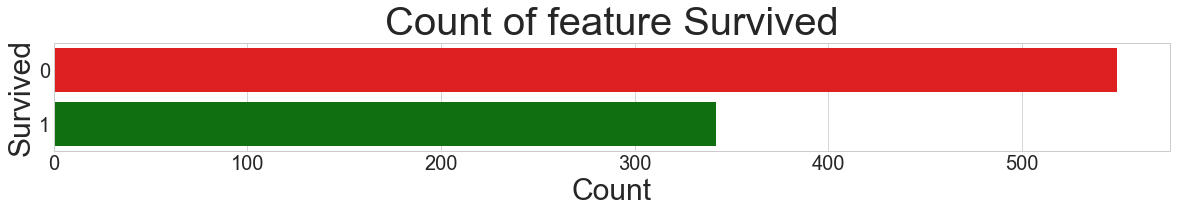

In [74]:
target = 'Survived'
feature = target

missing_val = find_missing_values(df_train,columns = df_train.columns)
print("The number of missing target values is".format(feature), + missing_val[feature])
simple_plot()

#### Conclusion: Our distribution of predictions should look similar

# *Feature: Pclass*
class 1st, 2nd or 3rd shows wealth and location on a ship. 1st class being closest to the escape route.

The number of missing values in column Pclass for TRAIN set is 0
The number of missing values in column Pclass for TEST set is 0
The data type is int64
_____________________________________________________________
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
_____________________________________________________________
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


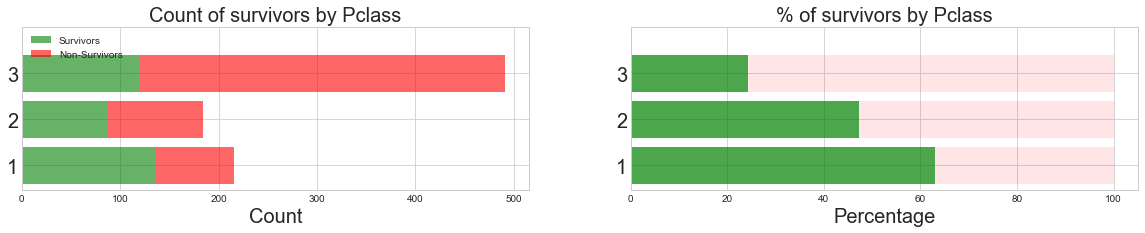

In [75]:
feature = 'Pclass'
show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

In [76]:
df_train[feature] = df_train[feature].astype("object")
df_test[feature] = df_test[feature].astype("object")

#### Conclusion: Included - Clearly visible indicator that people from 3rd class had less chance of survival, while 1st class had the best chance. 

# *Feature: Name*
Feature engineering adds new features "Title" and "Surname". We will also look into family relations, as people naturaly care about their love ones and that factor should have an impact on survival chance.

In [77]:
feature = 'Name'

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

The number of missing values in column Name for TRAIN set is 0
The number of missing values in column Name for TEST set is 0
The data type is object
_____________________________________________________________
There are 891 unique categories in feature Name


The number of missing values in column Title for TRAIN set is 0
The number of missing values in column Title for TEST set is 0
The data type is object
_____________________________________________________________
Title     Capt  Col  Don  Dr  Jonkheer  Lady  Major  Master  Miss  Mlle  Mme  \
Survived                                                                       
0            1    1    1   4         1     0      1      17    55     0    0   
1            0    1    0   3         0     1      1      23   127     2    1   

Title      Mr  Mrs  Ms  Rev  Sir  the Countess  
Survived                                        
0         436   26   0    6    0             0  
1          81   99   1    0    1             1  
_____________________________________________________________


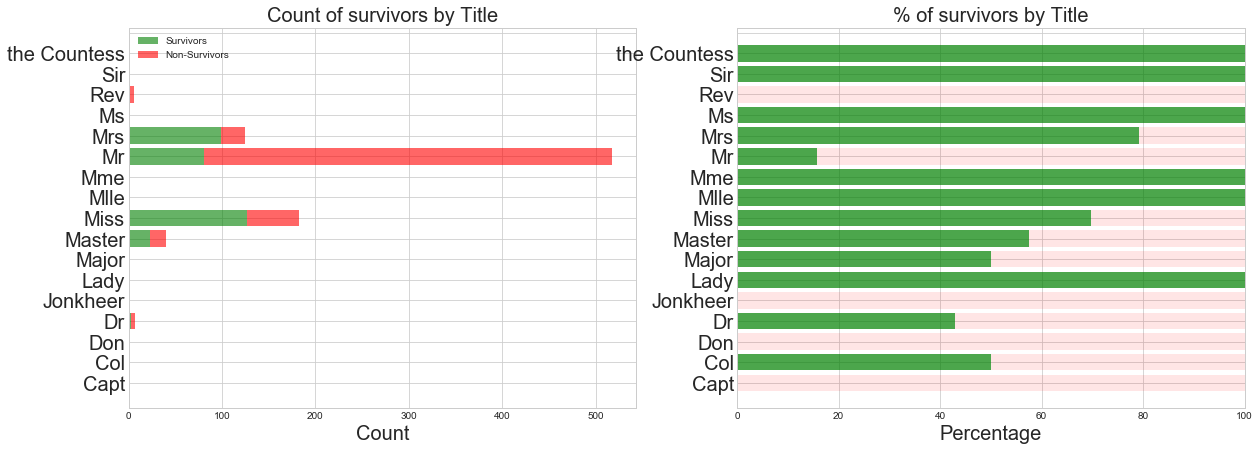

In [78]:
# Engineer Title

feature = 'Title'
made_from_feature = 'Name'

def engineer_title(row):
    before = row[made_from_feature]
    x = before.rsplit(",")
    after=x[1].strip().split(".")[0]
    return after 

# Apply to train set
df_train[feature] = df_train[made_from_feature]
df_train[feature]=df_train.apply(engineer_title, axis=1)

# Apply to test set
df_test[feature] = df_test[made_from_feature]
df_test[feature]=df_test.apply(engineer_title, axis=1)
show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

In [79]:
df_test[feature].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

#### Conclusion: We should group the singular cases together to avoid overfitting. As one might expect, the captain did went down with the ship and it is also not surprising to see, that all "Rev" (reverend) died too.  We will group them together with Jonkheer and Don because they all died. The rest of the rare titles will be grouped together. I will not make a distinction between male and females titles as that distinction will be covered by the feature sex. Please note that there is one extra title Dona in the test set, so we need to add that as well.

Title     Master  Miss   Mr  Mrs  On_duty  Rare
Survived                                       
0             17    55  436   26        9     6
1             23   127   81   99        0    12
_____________________________________________________________
     Title  Survived
3      Mrs  0.792000
1     Miss  0.697802
5     Rare  0.666667
0   Master  0.575000
2       Mr  0.156673
4  On_duty  0.000000


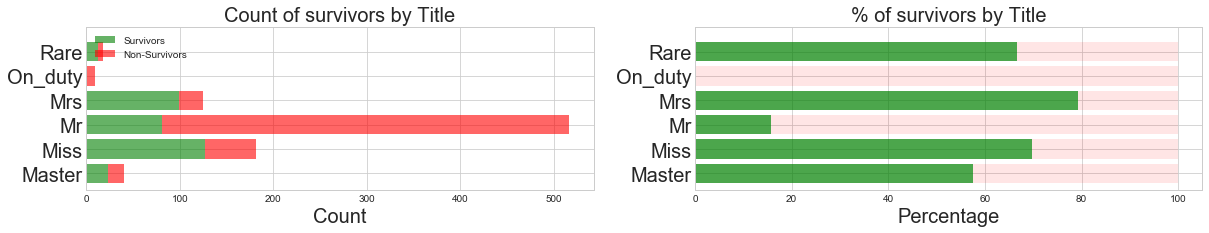

In [80]:
# Cleaning the noise

def replace_titles(row):
    title =row[feature]
    if title in ['Capt', 'Don', 'Jonkheer', 'Rev']:
        return 'On_duty'
    elif title in ['Lady', 'Sir', 'the Countess','Dona','Col', 'Dr', 'Major','Mlle', 'Mme', 'Ms']:
        return 'Rare'        
    else:
        return title
    
# Apply to train set    
df_train[feature] = df_train[feature]
df_train[feature]=df_train.apply(replace_titles, axis=1)

# Apply to test set
df_test[feature] = df_test[feature]
df_test[feature]=df_test.apply(replace_titles, axis=1)
show_info(data=df_train, show_missing_values = False, show_other = True)

In [81]:
feature = 'Surname'
made_from_feature = 'Name'

def engineer_surname(row):
   before = row['Name']
   x = before.rsplit(",")
   after=x[0].strip()
   return after

# Apply to train set
df_train[feature] = df_train[made_from_feature]
df_train[feature]=df_train.apply(engineer_surname, axis=1)

# Apply to test set
df_test[feature] = df_test[made_from_feature]
df_test[feature]=df_test.apply(engineer_surname, axis=1)

#### Conclusion: Include 'Title', and use "Surname" to find family connections (done later on)

# *Feature: Sex*

The number of missing values in column Sex for TRAIN set is 0
The number of missing values in column Sex for TEST set is 0
The data type is object
_____________________________________________________________
Sex       female  male
Survived              
0             81   468
1            233   109
_____________________________________________________________
      Sex  Survived
0  female  0.742038
1    male  0.188908


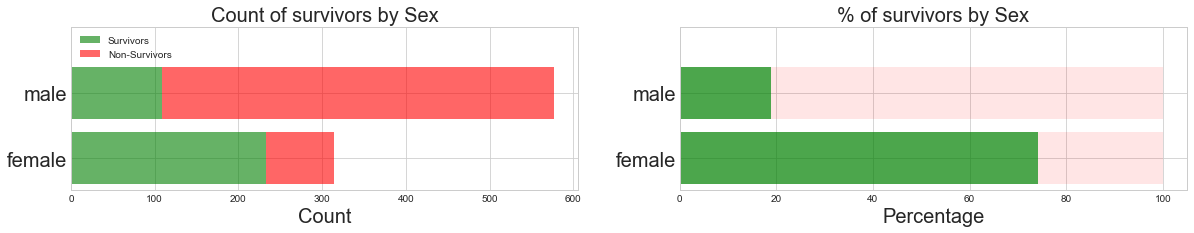

In [82]:
feature = 'Sex'

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

#### Conclusion: This is fantastic predictor! If we just could narrow down why some females died and why some male survived. I'm going to use catboost algorithm in this notebook, which is robust to multicolinearity (because of that I can safely add both Sex and title in my model)

# *Feature: Age*

In [83]:
feature = 'Age'

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

The number of missing values in column Age for TRAIN set is 177
The number of missing values in column Age for TEST set is 86
The data type is float64
_____________________________________________________________
There are 88 unique categories in feature Age


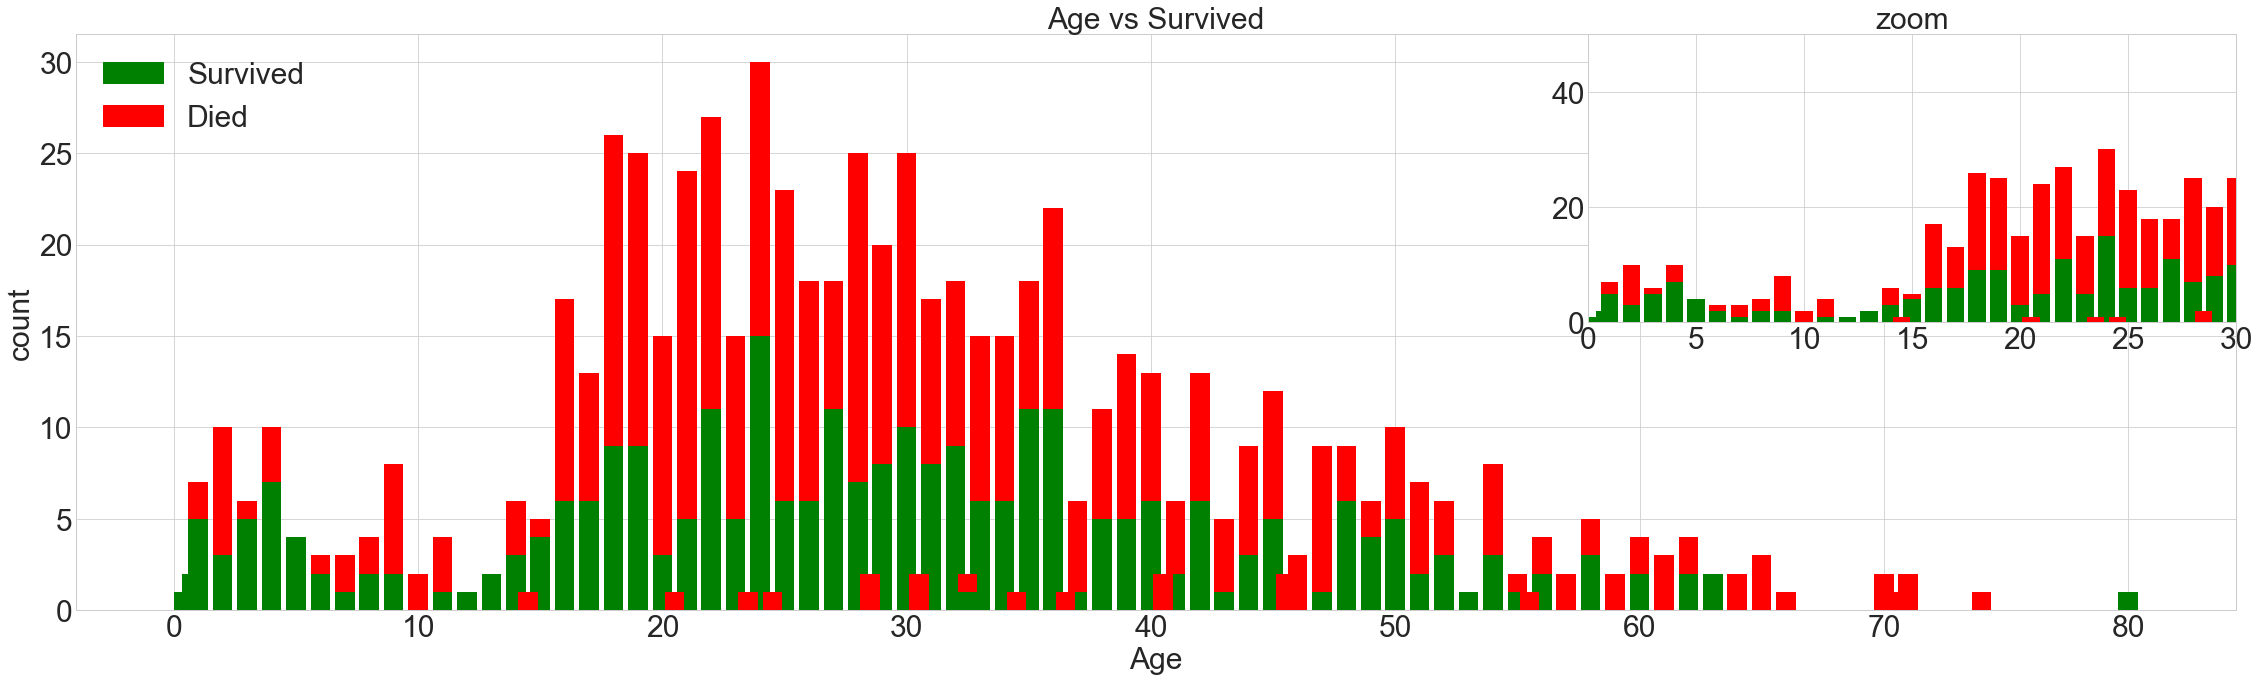

In [84]:
plot_continuous_as_discrete(df_train, label_size=30, xmin=0, xmax=30, ymin=0, ymax=50)

In [85]:
# Check for outliers

outliers_info(bounds_calculated_on=df_train, outlier_search_in=df_train)
df_train.iloc[outlier_indices]

Outliers detected in df_train for feature Age:
_______________________________________________________________
The lower bound value is -13.88037434994331. Number of outliers found in lower end: 0
_______________________________________________________________
The upper bound value is 73.27860964406095. Number of outliers found in upper end: 2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.000,A23,S,Mr,Barkworth
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.775,NaN,S,Mr,Svensson


In [86]:
outliers_info(bounds_calculated_on=df_train, outlier_search_in=df_test)
df_test.iloc[outlier_indices]

Outliers detected in df_test for feature Age:
_______________________________________________________________
The lower bound value is -13.88037434994331. Number of outliers found in lower end: 0
_______________________________________________________________
The upper bound value is 73.27860964406095. Number of outliers found in upper end: 1


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
96,988,1,"Cavendish, Mrs. Tyrell William (Julia Florence...",female,76.0,1,0,19877,78.85,C46,S,Mrs,Cavendish


In [87]:
'''
Since the oldest passenger on Titanic was 74 (based on facts), we suspect that the outliers are caused by wrong data.
In fact Mr Henry was 48 and Mrs Julia was 25 - we will correct the mistakes.
Mr. Johan's age is in fact correct, hence we will leave that entry in.
'''
column_index_train=df_train.columns.get_loc(feature)
column_index_test=df_train.columns.get_loc(feature)
df_train.iloc[630,column_index_train]=48
df_test.iloc[96,column_index_test]=25

#### Conclusions: Redundant - Unfortunately there is over 20% data missing! On top of that the imputing would be in big danger of inacuracy given that the data are of poor quality (wrong  values found indicate that more values can be wrong as well). However, let's extract at least some information here. After research on the disaster we know about "Women and children first" rule, https://en.wikipedia.org/wiki/Women_and_children_firstrule, that is associated with Titanic sinking. Therefore, let's try to find as many children as it is possible from this incomplete data.  We will engineer feature 'child'. Since I couldn't find any information about what age classified a child, I'm going to use little trick below:

In [88]:
# Youngest married woman on a ship - different times than now!
df_train[df_train['Title']=='Mrs'].min()['Age']

14.0

The number of missing values in column Child for TRAIN set is 0
The number of missing values in column Child for TEST set is 0
The data type is int64
_____________________________________________________________
Child       0   1
Survived         
0         520  29
1         300  42
_____________________________________________________________
   Child  Survived
1      1  0.591549
0      0  0.365854


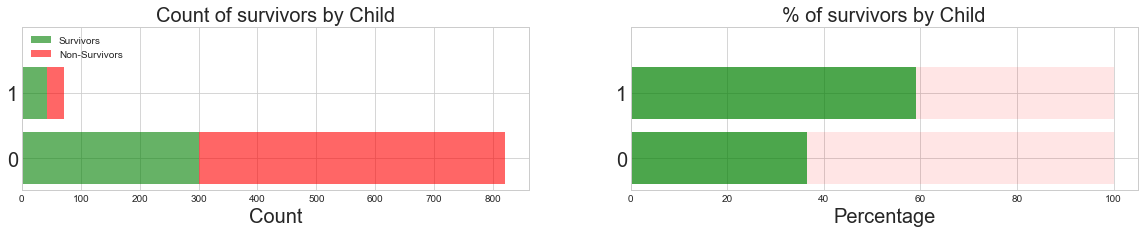

In [89]:
feature = 'Child'

def age_classification(row):
    value = row['Age']
    if value < 14:
        return 1
    else:
        return 0

df_train[feature]= df_train.apply(age_classification, axis=1) 
df_test[feature]= df_test.apply(age_classification, axis=1)

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

# *Feature SibSp*

The number of missing values in column SibSp for TRAIN set is 0
The number of missing values in column SibSp for TEST set is 0
The data type is int64
_____________________________________________________________
SibSp       0    1   2   3   4  5  8
Survived                            
0         398   97  15  12  15  5  7
1         210  112  13   4   3  0  0
_____________________________________________________________
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


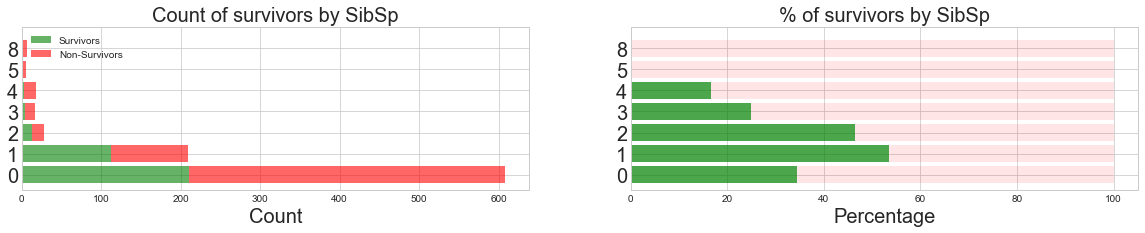

In [90]:
feature = 'SibSp'    # Number of siblings aboard

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

#### Conclusion: In tragic situations such as this, people tends to stay closely with their loved ones whether this is their sibling or a parent/child. Therefore we should merge those two features together. When people stay together, they might survive or die together, they are also morelikely to help a family member than a stranger so this new combine feature should have predictive power. 

# *Feature Parch*

The number of missing values in column Parch for TRAIN set is 0
The number of missing values in column Parch for TEST set is 0
The data type is int64
_____________________________________________________________
Parch       0   1   2  3  4  5  6
Survived                         
0         445  53  40  2  4  4  1
1         233  65  40  3  0  1  0
_____________________________________________________________
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


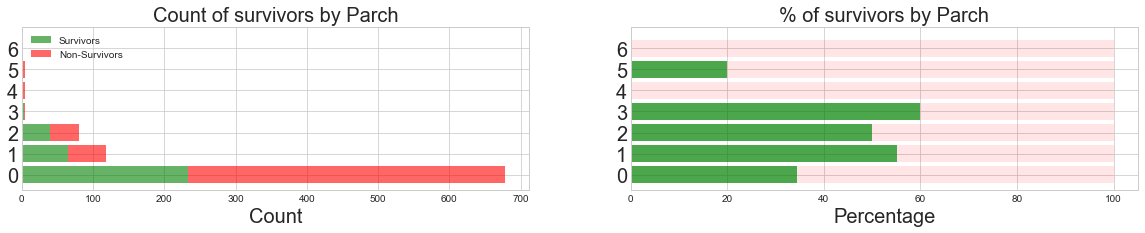

In [91]:
feature = 'Parch' # Number of parents/children aboard

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

#### Conclussion: One pattern emerges here - having large family seem to diminish chances of survival. As expected, it also seem to help not to be alone as on both graphs chances of survival increase, when having some family member with you. We will engineer two new features: "Large_family" and "Is_alone"

Large_family    0   1
Survived             
0             528  21
1             338   4
_____________________________________________________________
   Large_family  Survived
0             0    0.3903
1             1    0.1600


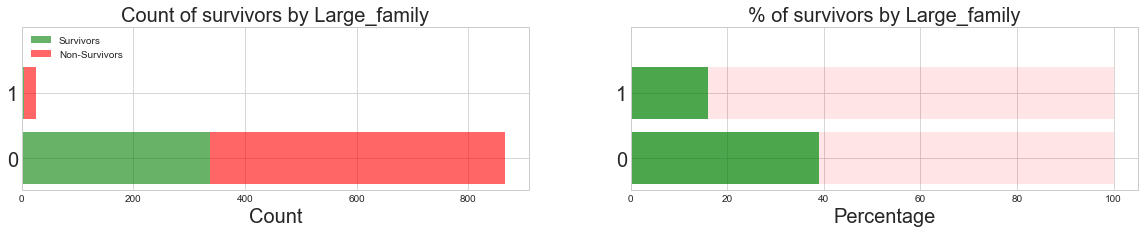

In [92]:
# Engineer 'Large_family' and " Is_alone"

feature = 'Sipb_and_Parch'

df_train[feature]=df_train['SibSp']+df_train['Parch']
df_test[feature]=df_test['SibSp']+df_test['Parch']

def family_size(row):
    value = row['Sipb_and_Parch']
    if value > 5:
        return 1
    else:
        return 0 
    
feature = 'Large_family'

df_train[feature]= df_train.apply(family_size, axis=1) 
df_test[feature]= df_test.apply(family_size, axis=1)
show_info(data=df_train, show_missing_values = False, show_other = True, show_graph=True)

Is_alone    0   1
Survived         
0         528  21
1         338   4
_____________________________________________________________
   Is_alone  Survived
0         0    0.3903
1         1    0.1600


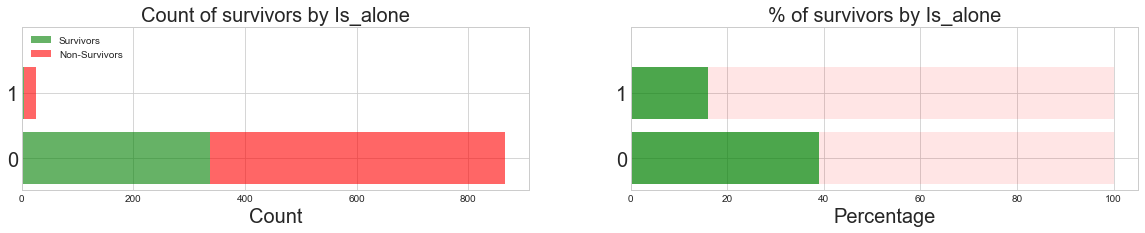

In [93]:
feature = 'Is_alone'

def alone(row):
    value = row['Sipb_and_Parch']
    if value == 0:
        return 1
    else:
        return 0 

df_train[feature]= df_train.apply(family_size, axis=1) 
df_test[feature]= df_test.apply(family_size, axis=1)

show_info(data=df_train, show_missing_values = False, show_other = True, show_graph=True)

# *Feature Ticket*

In [94]:
feature = 'Ticket'

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

The number of missing values in column Ticket for TRAIN set is 0
The number of missing values in column Ticket for TEST set is 0
The data type is object
_____________________________________________________________
There are 681 unique categories in feature Ticket


#### Conclusion: This feature can be more useful than it seem at the first glance. It could enable us to find family members more accurately (some people may have the same common surname but not be related) but also we could potentially find groups of friends. We will come back to this after exploring available features.

# *Feature Fare*

In [95]:
feature = 'Fare'

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

The number of missing values in column Fare for TRAIN set is 0
The number of missing values in column Fare for TEST set is 1
The data type is float64
_____________________________________________________________
There are 248 unique categories in feature Fare


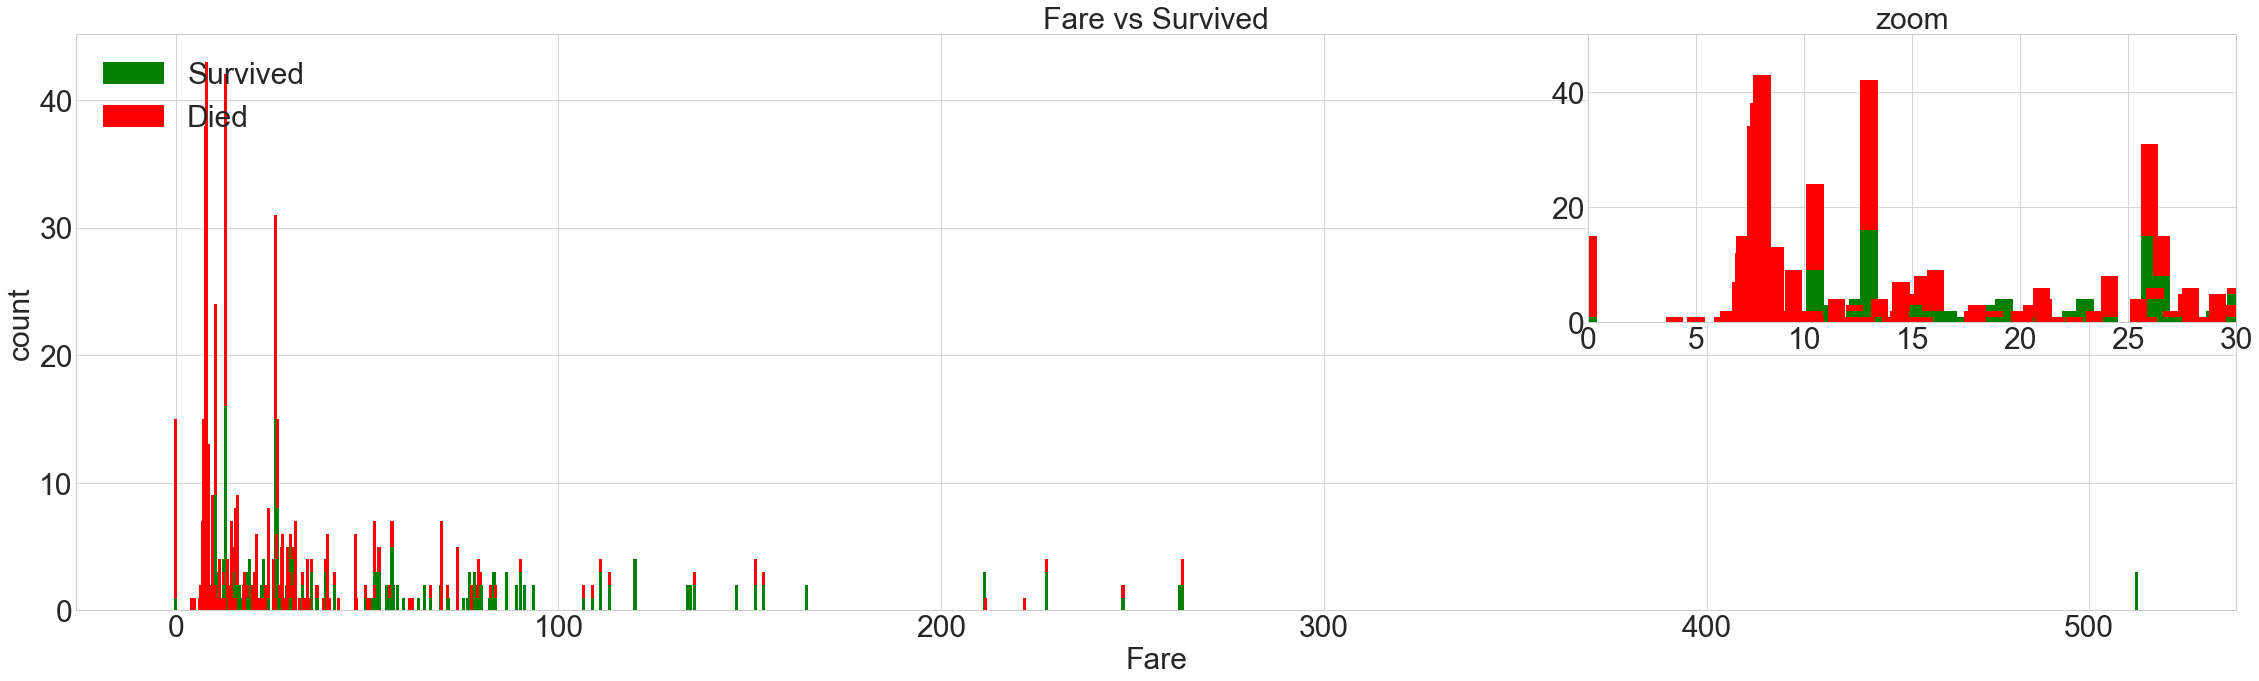

In [96]:
plot_continuous_as_discrete(df_train, label_size=30, xmin=0, xmax=30, ymin=0, ymax=50)

In [97]:
# Note on outliers 
'''
Important to understand is that outliers are an example of natural variation (very wealthy people) therefore should not be removed. 
Instead we will bin entire feature and put all outliers in one group. 
Because of that we will impute missing data first as it will capture the natural variation.
Mean is not suitable to use for skewed data with outliers such as this, so we will use median instead.
'''
# Apply to train set
outliers_info(bounds_calculated_on=df_train, outlier_search_in=df_train)
# Apply to test set
outliers_info(bounds_calculated_on=df_train, outlier_search_in=df_test)

Outliers detected in df_train for feature Fare:
_______________________________________________________________
The lower bound value is -116.87607782296811. Number of outliers found in lower end: 0
_______________________________________________________________
The upper bound value is 181.2844937601173. Number of outliers found in upper end: 20
Outliers detected in df_test for feature Fare:
_______________________________________________________________
The lower bound value is -116.87607782296811. Number of outliers found in lower end: 0
_______________________________________________________________
The upper bound value is 181.2844937601173. Number of outliers found in upper end: 18


In [98]:
# Viewing the missing value
index = df_test[feature].index[df_test[feature].apply(np.isnan)]
df_test.iloc[index]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Child,Sipb_and_Parch,Large_family,Is_alone
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,Storey,0,0,0,0


In [99]:
# Finding Passengers with same variables that Fare depends upon
df_selected = df_train[(df_train.Cabin.isnull())&(df_train.Pclass==3)&(df_train.Parch==0)&(df_train.SibSp==0)&(df_train.Embarked=='S')]
# Find the mode average Fare for those passengers and replace our Nan value with that figure
median = df_selected[feature].median()
median

7.9104

In [100]:
# Replace missing value
feature_index=df_test.columns.get_loc(feature)
df_test.iat[index[0],feature_index]= median
show_info(data=df_train, show_missing_values = True, show_other = False)

The number of missing values in column Fare for TRAIN set is 0
The number of missing values in column Fare for TEST set is 0
The data type is float64
_____________________________________________________________
There are 248 unique categories in feature Fare


#### Conclusions: Let's keep this feature for now but it may get redundant - it does imply the wealth of a passenger but does this have an impact of his/hers survival? Let's find out

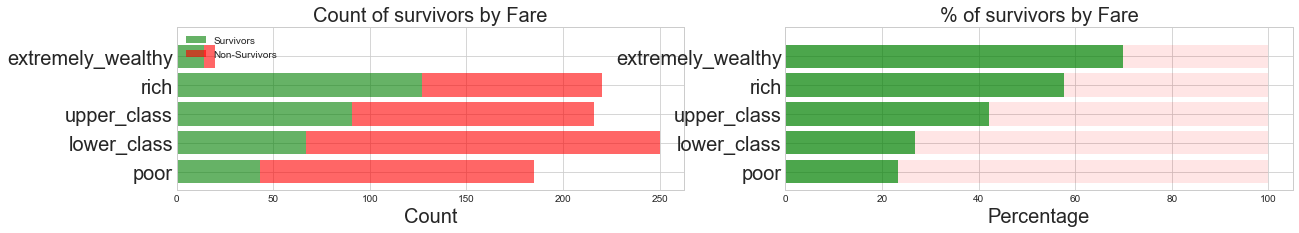

In [101]:
# Binning

# Outliers as one category
extreme_threshold = 181.284
# Rest of the passenger's thresholds
df_rest_of_passengers = df_train[df_train[feature]<extreme_threshold]
poor_threshold = df_rest_of_passengers[feature].quantile(0.25)
lower_class_threshold = df_rest_of_passengers[feature].quantile(0.50)
upper_class_threshold = df_rest_of_passengers[feature].quantile(0.75)

# creating bins
labels = ['poor', 'lower_class', 'upper_class', 'rich','extremely_wealthy']
bins = [0,poor_threshold, lower_class_threshold, upper_class_threshold, extreme_threshold, np.inf]
df_train[feature] = pd.cut(df_train[feature], bins, right=False, labels=labels)
df_test[feature] = pd.cut(df_test[feature], bins, right=False, labels=labels)
show_info(data=df_train, show_missing_values = False, show_other = False, show_graph=True)

# *Feature Cabin*

In [102]:
feature = 'Cabin'

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

The number of missing values in column Cabin for TRAIN set is 687
The number of missing values in column Cabin for TEST set is 327
The data type is object
_____________________________________________________________
There are 147 unique categories in feature Cabin


The number of missing values in column Cabin for TRAIN set is 0
The number of missing values in column Cabin for TEST set is 0
The data type is object
_____________________________________________________________
Cabin     A   B   C   D   E  F  G    N
Survived                              
0         8  12  24   8   8  5  2  482
1         7  35  35  25  24  8  2  206
_____________________________________________________________
  Cabin  Survived
3     D  0.757576
4     E  0.750000
1     B  0.744681
5     F  0.615385
2     C  0.593220
6     G  0.500000
0     A  0.466667
7     N  0.299419


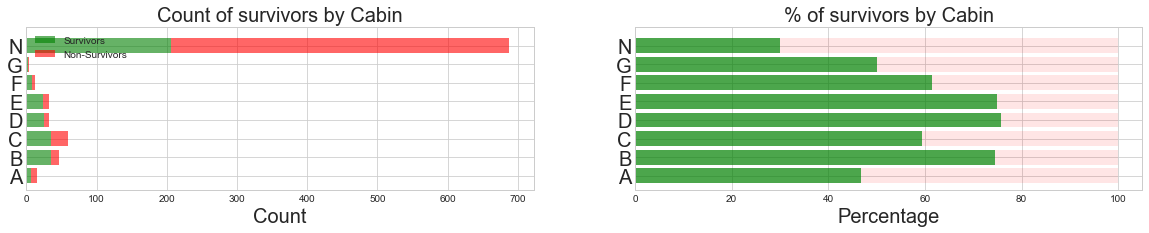

In [103]:
'''
77% of data is missing, one passenger has assigned cabin T which was on a boat deck.
We will remove the number and only keep the deck letter.
All passengers with missing cabin will be assigned cabin N (non existing), as well as T will be replaced with N as well
'''
feature = 'Cabin'

def replace_with_first_letter(row):
    string =row[feature]
    return string[0]

# Dealing with missing data by replacing with N
df_train[feature].replace(np.nan, 'N', inplace=True)
df_test[feature].replace(np.nan, 'N', inplace=True)

# Replacing with only first letter
df_train[feature]=df_train.apply(replace_with_first_letter, axis=1)
df_test[feature]=df_test.apply(replace_with_first_letter, axis=1)

# One passenger has assigned cabin T - we will change it to N as well
df_train[feature].replace('T', 'N', inplace=True)

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

#### Conclusion: Although this feature does show location on a ship but not as well as Pclass. As before, we will keep it for now and review it later.

# *Feature Embarked* 

The number of missing values in column Embarked for TRAIN set is 2
The number of missing values in column Embarked for TEST set is 0
The data type is object
_____________________________________________________________
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217
_____________________________________________________________
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


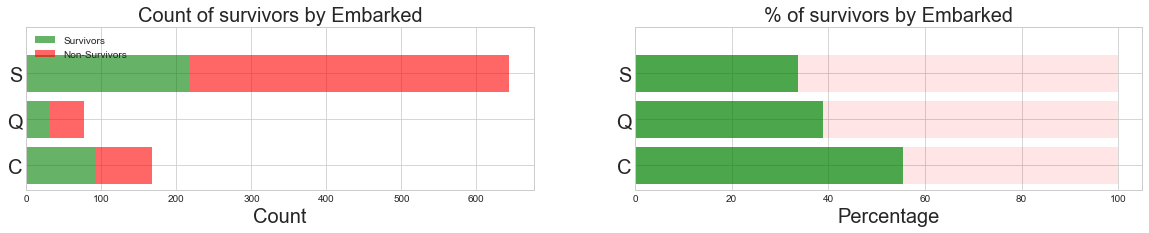

In [104]:
feature = 'Embarked'

show_info(data=df_train, show_missing_values = True, show_other = True, show_graph=True)

In [105]:
'''Since there are only two values and we could find the true values from
https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html 
The missing value for both missing data is S
'''
df_train[feature].replace(np.nan, 'S', inplace=True)

#### Conclusion: This feature should not have predictive power so we will try it for now but most likely it will become redundant.

##############################################################################################################################
# Advanced feature engineering - creating new feature 'Connections'
##############################################################################################################################

In [106]:
'''
We will temporarily merge df_train and df_test together in order to find family and friends connections. 
Please note, the labels in the test set are still unknown, therefore we do not add bias or data leakage.
We only use it to see patterns and connections between test set and training set.
The model will be trained on training set only.
'''
df = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
df=df[['PassengerId','Survived','Sex','Title','Surname','Fare','Pclass','Cabin','Embarked','Child','Is_alone','Large_family','Ticket']]

In [107]:
feature = 'Ticket_count'

def AddColumnCount(row):   
    row[feature] = column_count[row['Ticket']]
    return row
 
column_count=df.groupby('Ticket').count()['PassengerId']
df = df.apply(AddColumnCount,axis=1)

In [108]:
feature = 'Connections'

def connections(row):
    count = row['Ticket_count']
    number = row['Ticket']
    if count >3:
        return number
    else:
        return 0

df[feature]= df.apply(connections, axis=1)
df['Connections'].unique()

array([0, '349909', '347082', '382652', '347077', '19950',
       'SC/Paris 2123', '3101295', 'C.A. 34651', 'CA 2144', '347088',
       'S.O.C. 14879', '1601', 'W./C. 6608', 'C.A. 2315', 'C.A. 33112',
       'CA. 2343', '4133', 'LINE', '230136', 'PC 17755', 'PC 17760',
       '113781', '17421', 'PC 17608', '36928', '16966', '113503',
       'PC 17757', '113760', '2666', '12749', 'PC 17483', '220845',
       '24160', 'W./C. 6607'], dtype=object)

----------------------------------------------------
##################################################################################################################################################################################
# Feature selection
##################################################################################################################################################################################

In [109]:
# View all features
df.head(1)

,PassengerId,Survived,Sex,Title,Surname,Fare,Pclass,Cabin,Embarked,Child,Is_alone,Large_family,Ticket,Ticket_count,Connections
0,1,0.0,male,Mr,Braund,poor,3,N,S,0,0,0,A/5 21171,1,0


In [110]:
# Select desired features
df_selected = df[['Sex', 'Title','Ticket','Pclass']]
df_labels = df[['Survived']]
df_selected.head(1)

,Sex,Title,Ticket,Pclass
0,male,Mr,A/5 21171,3


In [111]:
# Separating train and test set
train=df_selected.loc[:890]
test=df_selected.loc[891:]
train_labels = df_labels.loc[:890]

----------------------------------------------------
##################################################################################################################################################################################
# Preparation for Machine learning
##################################################################################################################################################################################

In [112]:
# One hot Encoding 
train_ready = pd.get_dummies(train)
test_ready = pd.get_dummies(test)
train_ready.head()

,Pclass,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_On_duty,Title_Rare,Ticket_110152,...,Ticket_STON/O2. 3101290,Ticket_SW/PP 751,Ticket_W./C. 14258,Ticket_W./C. 14263,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735
0,3,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
# Aligning data frames (Some connections that we discovered will be now redundant as they are not present in both sets)
train_ready, test_ready = train_ready.align(test_ready, join='inner', axis=1)

In [114]:
train_ready.shape

(891, 124)

In [115]:
test_ready.shape

(418, 124)

In [116]:
train_ready.columns

Index(['Pclass', 'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_On_duty', 'Title_Rare', 'Ticket_110813',
       ...
       'Ticket_PP 9549', 'Ticket_S.C./PARIS 2079', 'Ticket_S.O.C. 14879',
       'Ticket_SC/AH 29037', 'Ticket_SC/AH 3085', 'Ticket_SC/PARIS 2167',
       'Ticket_SC/Paris 2123', 'Ticket_W./C. 6607', 'Ticket_W./C. 6608',
       'Ticket_W.E.P. 5734'],
      dtype='object', length=124)

##################################################################################################################################################################################
# Machine Learning Algorithms !!!
##################################################################################################################################################################################

In [118]:
#Split the data frame into data and labels 
X_train = train_ready
y_train = df_train[target]

# Define Machine learning algorithm
def fit_ml_algo(algo, X_train, y_train, cv):
    model = algo.fit(X_train,y_train)
    acc = round(model.score(X_train,y_train)*100,2)
    
    #Cross Validation
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                   n_jobs= -1)
    # Cross Validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train,train_pred)*100,2)
    
    return train_pred, acc, acc_cv

# Logistic Regression

In [119]:
#Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), X_train, y_train,10)

log_time = (time.time() - start_time)

print('Accuracy: %s' % acc_log)
print('Accuracy CV 10 Fold: %s' % acc_cv_log)
print('Running Time: %s' %datetime.timedelta(seconds=log_time))

Accuracy: 83.84
Accuracy CV 10 Fold: 82.27
Running Time: 0:00:01.725147


# KNN

In [120]:
# KNN
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),
                                                 X_train,
                                                 y_train,
                                                  10)
knn_time = (time.time() - start_time)

print('Accuracy: %s' % acc_knn)
print('Accuracy CV 10 Fold: %s' % acc_cv_knn)
print('Running Time: %s' %datetime.timedelta(seconds=knn_time))

Accuracy: 81.93
Accuracy CV 10 Fold: 78.23
Running Time: 0:00:00.191594


In [121]:
test_ready.columns

Index(['Pclass', 'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_On_duty', 'Title_Rare', 'Ticket_110813',
       ...
       'Ticket_PP 9549', 'Ticket_S.C./PARIS 2079', 'Ticket_S.O.C. 14879',
       'Ticket_SC/AH 29037', 'Ticket_SC/AH 3085', 'Ticket_SC/PARIS 2167',
       'Ticket_SC/Paris 2123', 'Ticket_W./C. 6607', 'Ticket_W./C. 6608',
       'Ticket_W.E.P. 5734'],
      dtype='object', length=124)

# Gaussian Naive Bayes

In [122]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(),
                                                 X_train,
                                                 y_train,
                                                  10)
gaussian_time = (time.time() - start_time)

print('Accuracy: %s' % acc_gaussian)
print('Accuracy CV 10 Fold: %s' % acc_cv_gaussian)
print('Running Time: %s' %datetime.timedelta(seconds=gaussian_time))

Accuracy: 70.71
Accuracy CV 10 Fold: 66.78
Running Time: 0:00:00.039892


# Linear Support Vector Machines (SVC)

In [123]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 85.07
Accuracy CV 10-Fold: 83.05
Running Time: 0:00:00.167981


# Stochastic Gradient Descent

In [124]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),
                                                 X_train,
                                                 y_train,
                                                  10)
sgd_time = (time.time() - start_time)

print('Accuracy: %s' % acc_sgd)
print('Accuracy CV 10 Fold: %s' % acc_cv_sgd)
print('Running Time: %s' %datetime.timedelta(seconds=sgd_time))

Accuracy: 85.07
Accuracy CV 10 Fold: 77.55
Running Time: 0:00:00.113695


# Decision Tree Classifier

In [125]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),
                                                 X_train,
                                                 y_train,
                                                  10)
dt_time = (time.time() - start_time)

print('Accuracy: %s' % acc_dt)
print('Accuracy CV 10 Fold: %s' % acc_cv_dt)
print('Running Time: %s' %datetime.timedelta(seconds=dt_time))

Accuracy: 85.19
Accuracy CV 10 Fold: 81.14
Running Time: 0:00:00.117723


# Gradient Boost Tree

In [126]:
# Gradient Boost Tree
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                                 X_train,
                                                 y_train,
                                                  10)
gbt_time = (time.time() - start_time)

print('Accuracy: %s' % acc_gbt)
print('Accuracy CV 10 Fold: %s' % acc_cv_gbt)
print('Running Time: %s' %datetime.timedelta(seconds=gbt_time))

Accuracy: 85.07
Accuracy CV 10 Fold: 82.49
Running Time: 0:00:00.783266


# Catboost Algorithm

In [127]:
#Catboost Algorithm
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

# Use the CatBoost pool () function to pool together the training data and the categorical feature labels

train_pool = Pool(X_train, y_train, cat_features)
#CatBoost Model definition
catboost_model = CatBoostClassifier(iterations = 1000, custom_loss=['Accuracy'],loss_function = 'Logloss')

#Fit the CatBoost Model 
catboost_model.fit(train_pool, plot= True)

acc_catboost = round(catboost_model.score(X_train,y_train),2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009807
0:	learn: 0.6869563	total: 44.3ms	remaining: 44.3s
1:	learn: 0.6815502	total: 52.3ms	remaining: 26.1s
2:	learn: 0.6765898	total: 59.9ms	remaining: 19.9s
3:	learn: 0.6716889	total: 75.6ms	remaining: 18.8s
4:	learn: 0.6656615	total: 92.3ms	remaining: 18.4s
5:	learn: 0.6604104	total: 116ms	remaining: 19.2s
6:	learn: 0.6555817	total: 124ms	remaining: 17.5s
7:	learn: 0.6511695	total: 125ms	remaining: 15.5s
8:	learn: 0.6458905	total: 148ms	remaining: 16.3s
9:	learn: 0.6410653	total: 150ms	remaining: 14.8s
10:	learn: 0.6361150	total: 172ms	remaining: 15.5s
11:	learn: 0.6311586	total: 207ms	remaining: 17s
12:	learn: 0.6264211	total: 222ms	remaining: 16.8s
13:	learn: 0.6223318	total: 223ms	remaining: 15.7s
14:	learn: 0.6178071	total: 239ms	remaining: 15.7s
15:	learn: 0.6129247	total: 263ms	remaining: 16.2s
16:	learn: 0.6087514	total: 281ms	remaining: 16.2s
17:	learn: 0.6047658	total: 290ms	remaining: 15.8s
18:	learn: 0.6009762	total: 299ms	remaining: 15.4s
19:	lear

166:	learn: 0.4285167	total: 1.76s	remaining: 8.76s
167:	learn: 0.4282076	total: 1.78s	remaining: 8.8s
168:	learn: 0.4279769	total: 1.79s	remaining: 8.81s
169:	learn: 0.4277251	total: 1.79s	remaining: 8.76s
170:	learn: 0.4276076	total: 1.79s	remaining: 8.71s
171:	learn: 0.4274471	total: 1.81s	remaining: 8.71s
172:	learn: 0.4272790	total: 1.82s	remaining: 8.72s
173:	learn: 0.4269855	total: 1.83s	remaining: 8.67s
174:	learn: 0.4268998	total: 1.83s	remaining: 8.62s
175:	learn: 0.4267375	total: 1.83s	remaining: 8.57s
176:	learn: 0.4265319	total: 1.86s	remaining: 8.63s
177:	learn: 0.4263505	total: 1.86s	remaining: 8.58s
178:	learn: 0.4263101	total: 1.86s	remaining: 8.53s
179:	learn: 0.4261346	total: 1.88s	remaining: 8.54s
180:	learn: 0.4259746	total: 1.89s	remaining: 8.55s
181:	learn: 0.4257372	total: 1.92s	remaining: 8.63s
182:	learn: 0.4256621	total: 1.92s	remaining: 8.58s
183:	learn: 0.4254731	total: 1.94s	remaining: 8.6s
184:	learn: 0.4252432	total: 1.96s	remaining: 8.64s
185:	learn: 0.

333:	learn: 0.4083497	total: 3.86s	remaining: 7.69s
334:	learn: 0.4082777	total: 3.86s	remaining: 7.66s
335:	learn: 0.4081432	total: 3.87s	remaining: 7.64s
336:	learn: 0.4080185	total: 3.89s	remaining: 7.65s
337:	learn: 0.4079727	total: 3.9s	remaining: 7.63s
338:	learn: 0.4078959	total: 3.9s	remaining: 7.61s
339:	learn: 0.4078913	total: 3.9s	remaining: 7.57s
340:	learn: 0.4077799	total: 3.91s	remaining: 7.56s
341:	learn: 0.4077066	total: 3.91s	remaining: 7.53s
342:	learn: 0.4076435	total: 3.94s	remaining: 7.55s
343:	learn: 0.4076174	total: 3.94s	remaining: 7.52s
344:	learn: 0.4075452	total: 3.95s	remaining: 7.5s
345:	learn: 0.4074430	total: 3.97s	remaining: 7.5s
346:	learn: 0.4073516	total: 3.98s	remaining: 7.49s
347:	learn: 0.4072860	total: 3.98s	remaining: 7.46s
348:	learn: 0.4072306	total: 3.99s	remaining: 7.44s
349:	learn: 0.4071384	total: 4.01s	remaining: 7.44s
350:	learn: 0.4069921	total: 4.01s	remaining: 7.42s
351:	learn: 0.4069422	total: 4.02s	remaining: 7.4s
352:	learn: 0.4068

506:	learn: 0.3966069	total: 5.83s	remaining: 5.67s
507:	learn: 0.3965796	total: 5.83s	remaining: 5.64s
508:	learn: 0.3965479	total: 5.83s	remaining: 5.62s
509:	learn: 0.3964935	total: 5.85s	remaining: 5.62s
510:	learn: 0.3964182	total: 5.87s	remaining: 5.62s
511:	learn: 0.3963656	total: 5.89s	remaining: 5.62s
512:	learn: 0.3962862	total: 5.9s	remaining: 5.6s
513:	learn: 0.3962443	total: 5.93s	remaining: 5.61s
514:	learn: 0.3962226	total: 5.94s	remaining: 5.59s
515:	learn: 0.3962142	total: 5.94s	remaining: 5.57s
516:	learn: 0.3961579	total: 5.96s	remaining: 5.57s
517:	learn: 0.3960840	total: 5.97s	remaining: 5.56s
518:	learn: 0.3960595	total: 5.98s	remaining: 5.54s
519:	learn: 0.3960002	total: 5.99s	remaining: 5.53s
520:	learn: 0.3959113	total: 5.99s	remaining: 5.51s
521:	learn: 0.3958254	total: 6s	remaining: 5.49s
522:	learn: 0.3957977	total: 6s	remaining: 5.47s
523:	learn: 0.3957901	total: 6s	remaining: 5.45s
524:	learn: 0.3957628	total: 6s	remaining: 5.43s
525:	learn: 0.3956841	tota

676:	learn: 0.3874858	total: 7.79s	remaining: 3.71s
677:	learn: 0.3874268	total: 7.8s	remaining: 3.7s
678:	learn: 0.3873810	total: 7.81s	remaining: 3.69s
679:	learn: 0.3873589	total: 7.81s	remaining: 3.68s
680:	learn: 0.3872806	total: 7.84s	remaining: 3.67s
681:	learn: 0.3872400	total: 7.86s	remaining: 3.66s
682:	learn: 0.3871329	total: 7.88s	remaining: 3.66s
683:	learn: 0.3870911	total: 7.9s	remaining: 3.65s
684:	learn: 0.3870771	total: 7.91s	remaining: 3.64s
685:	learn: 0.3870287	total: 7.94s	remaining: 3.63s
686:	learn: 0.3870084	total: 7.94s	remaining: 3.62s
687:	learn: 0.3869704	total: 7.96s	remaining: 3.61s
688:	learn: 0.3868872	total: 7.98s	remaining: 3.6s
689:	learn: 0.3868039	total: 8s	remaining: 3.59s
690:	learn: 0.3867300	total: 8.01s	remaining: 3.58s
691:	learn: 0.3866465	total: 8.03s	remaining: 3.58s
692:	learn: 0.3865863	total: 8.04s	remaining: 3.56s
693:	learn: 0.3864924	total: 8.04s	remaining: 3.55s
694:	learn: 0.3864309	total: 8.07s	remaining: 3.54s
695:	learn: 0.38634

840:	learn: 0.3782898	total: 10.4s	remaining: 1.97s
841:	learn: 0.3782390	total: 10.4s	remaining: 1.96s
842:	learn: 0.3781752	total: 10.5s	remaining: 1.95s
843:	learn: 0.3781067	total: 10.5s	remaining: 1.94s
844:	learn: 0.3780232	total: 10.5s	remaining: 1.93s
845:	learn: 0.3779360	total: 10.5s	remaining: 1.92s
846:	learn: 0.3778921	total: 10.5s	remaining: 1.9s
847:	learn: 0.3778156	total: 10.5s	remaining: 1.89s
848:	learn: 0.3777627	total: 10.6s	remaining: 1.88s
849:	learn: 0.3776841	total: 10.6s	remaining: 1.87s
850:	learn: 0.3775871	total: 10.6s	remaining: 1.85s
851:	learn: 0.3775045	total: 10.6s	remaining: 1.84s
852:	learn: 0.3774564	total: 10.6s	remaining: 1.83s
853:	learn: 0.3774192	total: 10.7s	remaining: 1.82s
854:	learn: 0.3773257	total: 10.7s	remaining: 1.81s
855:	learn: 0.3772584	total: 10.7s	remaining: 1.8s
856:	learn: 0.3772234	total: 10.7s	remaining: 1.79s
857:	learn: 0.3771540	total: 10.8s	remaining: 1.78s
858:	learn: 0.3770724	total: 10.8s	remaining: 1.77s
859:	learn: 0.

In [128]:
acc_catboost

# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=False)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

# Catboost metrics

print('----Catboost Metrics----')
print('Accuracy:{}'.format(acc_catboost))
print('Accuracy CV 10-Fold:{}'.format(acc_cv_catboost))
print('Running Time:{}' .format(datetime.timedelta(seconds = catboost_time)))

0:	learn: 0.6793270	test: 0.6797417	best: 0.6797417 (0)	total: 629ms	remaining: 10m 28s
1:	learn: 0.6658736	test: 0.6667326	best: 0.6667326 (1)	total: 1.06s	remaining: 8m 47s
2:	learn: 0.6508660	test: 0.6515701	best: 0.6515701 (2)	total: 1.44s	remaining: 7m 57s
3:	learn: 0.6368475	test: 0.6381003	best: 0.6381003 (3)	total: 1.79s	remaining: 7m 26s
4:	learn: 0.6241861	test: 0.6254491	best: 0.6254491 (4)	total: 2.13s	remaining: 7m 4s
5:	learn: 0.6115002	test: 0.6129309	best: 0.6129309 (5)	total: 2.49s	remaining: 6m 52s
6:	learn: 0.5999297	test: 0.6012016	best: 0.6012016 (6)	total: 2.86s	remaining: 6m 45s
7:	learn: 0.5886060	test: 0.5898822	best: 0.5898822 (7)	total: 3.24s	remaining: 6m 41s
8:	learn: 0.5784003	test: 0.5800537	best: 0.5800537 (8)	total: 3.63s	remaining: 6m 39s
9:	learn: 0.5691926	test: 0.5712113	best: 0.5712113 (9)	total: 3.94s	remaining: 6m 29s
10:	learn: 0.5603144	test: 0.5625121	best: 0.5625121 (10)	total: 4.27s	remaining: 6m 24s
11:	learn: 0.5521360	test: 0.5545201	best

94:	learn: 0.4125884	test: 0.4314655	best: 0.4314655 (94)	total: 32.3s	remaining: 5m 7s
95:	learn: 0.4122104	test: 0.4312935	best: 0.4312935 (95)	total: 32.6s	remaining: 5m 7s
96:	learn: 0.4119017	test: 0.4311086	best: 0.4311086 (96)	total: 33s	remaining: 5m 6s
97:	learn: 0.4115631	test: 0.4307080	best: 0.4307080 (97)	total: 33.3s	remaining: 5m 6s
98:	learn: 0.4113326	test: 0.4305716	best: 0.4305716 (98)	total: 33.7s	remaining: 5m 6s
99:	learn: 0.4110249	test: 0.4303766	best: 0.4303766 (99)	total: 34s	remaining: 5m 6s
100:	learn: 0.4106637	test: 0.4302108	best: 0.4302108 (100)	total: 34.4s	remaining: 5m 6s
101:	learn: 0.4104383	test: 0.4299883	best: 0.4299883 (101)	total: 34.7s	remaining: 5m 5s
102:	learn: 0.4101856	test: 0.4298627	best: 0.4298627 (102)	total: 35s	remaining: 5m 4s
103:	learn: 0.4098800	test: 0.4298066	best: 0.4298066 (103)	total: 35.4s	remaining: 5m 4s
104:	learn: 0.4096309	test: 0.4296373	best: 0.4296373 (104)	total: 35.7s	remaining: 5m 4s
105:	learn: 0.4093007	test: 

185:	learn: 0.3927232	test: 0.4229878	best: 0.4229878 (185)	total: 1m 2s	remaining: 4m 34s
186:	learn: 0.3925272	test: 0.4229420	best: 0.4229420 (186)	total: 1m 3s	remaining: 4m 34s
187:	learn: 0.3923232	test: 0.4228808	best: 0.4228808 (187)	total: 1m 3s	remaining: 4m 34s
188:	learn: 0.3920913	test: 0.4228493	best: 0.4228493 (188)	total: 1m 3s	remaining: 4m 33s
189:	learn: 0.3919621	test: 0.4227944	best: 0.4227944 (189)	total: 1m 4s	remaining: 4m 33s
190:	learn: 0.3918057	test: 0.4226507	best: 0.4226507 (190)	total: 1m 4s	remaining: 4m 32s
191:	learn: 0.3916172	test: 0.4225916	best: 0.4225916 (191)	total: 1m 4s	remaining: 4m 32s
192:	learn: 0.3914676	test: 0.4224971	best: 0.4224971 (192)	total: 1m 5s	remaining: 4m 31s
193:	learn: 0.3912966	test: 0.4224270	best: 0.4224270 (193)	total: 1m 5s	remaining: 4m 31s
194:	learn: 0.3911555	test: 0.4223524	best: 0.4223524 (194)	total: 1m 5s	remaining: 4m 31s
195:	learn: 0.3909600	test: 0.4222763	best: 0.4222763 (195)	total: 1m 6s	remaining: 4m 30s

275:	learn: 0.3765404	test: 0.4151950	best: 0.4151950 (275)	total: 1m 36s	remaining: 4m 11s
276:	learn: 0.3763796	test: 0.4151870	best: 0.4151870 (276)	total: 1m 36s	remaining: 4m 11s
277:	learn: 0.3762132	test: 0.4150531	best: 0.4150531 (277)	total: 1m 36s	remaining: 4m 11s
278:	learn: 0.3760705	test: 0.4149685	best: 0.4149685 (278)	total: 1m 37s	remaining: 4m 11s
279:	learn: 0.3758652	test: 0.4147971	best: 0.4147971 (279)	total: 1m 37s	remaining: 4m 11s
280:	learn: 0.3756712	test: 0.4147938	best: 0.4147938 (280)	total: 1m 38s	remaining: 4m 11s
281:	learn: 0.3754674	test: 0.4146641	best: 0.4146641 (281)	total: 1m 38s	remaining: 4m 11s
282:	learn: 0.3752723	test: 0.4144645	best: 0.4144645 (282)	total: 1m 39s	remaining: 4m 11s
283:	learn: 0.3750523	test: 0.4143970	best: 0.4143970 (283)	total: 1m 39s	remaining: 4m 11s
284:	learn: 0.3748196	test: 0.4143844	best: 0.4143844 (284)	total: 1m 40s	remaining: 4m 11s
285:	learn: 0.3746503	test: 0.4141098	best: 0.4141098 (285)	total: 1m 40s	remain

365:	learn: 0.3618542	test: 0.4056112	best: 0.4056112 (365)	total: 2m 19s	remaining: 4m 1s
366:	learn: 0.3617288	test: 0.4055120	best: 0.4055120 (366)	total: 2m 19s	remaining: 4m
367:	learn: 0.3615864	test: 0.4053996	best: 0.4053996 (367)	total: 2m 20s	remaining: 4m
368:	learn: 0.3614477	test: 0.4053122	best: 0.4053122 (368)	total: 2m 20s	remaining: 4m
369:	learn: 0.3612878	test: 0.4051667	best: 0.4051667 (369)	total: 2m 21s	remaining: 4m
370:	learn: 0.3611498	test: 0.4051025	best: 0.4051025 (370)	total: 2m 21s	remaining: 4m
371:	learn: 0.3610324	test: 0.4050631	best: 0.4050631 (371)	total: 2m 22s	remaining: 3m 59s
372:	learn: 0.3609022	test: 0.4049458	best: 0.4049458 (372)	total: 2m 22s	remaining: 3m 59s
373:	learn: 0.3607750	test: 0.4049424	best: 0.4049424 (373)	total: 2m 23s	remaining: 3m 59s
374:	learn: 0.3606198	test: 0.4048509	best: 0.4048509 (374)	total: 2m 23s	remaining: 3m 59s
375:	learn: 0.3605252	test: 0.4047740	best: 0.4047740 (375)	total: 2m 23s	remaining: 3m 58s
376:	lear

455:	learn: 0.3522493	test: 0.3998575	best: 0.3998575 (455)	total: 2m 59s	remaining: 3m 34s
456:	learn: 0.3521597	test: 0.3998273	best: 0.3998273 (456)	total: 3m	remaining: 3m 34s
457:	learn: 0.3520682	test: 0.3998314	best: 0.3998273 (456)	total: 3m	remaining: 3m 33s
458:	learn: 0.3519402	test: 0.3997605	best: 0.3997605 (458)	total: 3m 1s	remaining: 3m 33s
459:	learn: 0.3518444	test: 0.3996952	best: 0.3996952 (459)	total: 3m 1s	remaining: 3m 33s
460:	learn: 0.3517745	test: 0.3996792	best: 0.3996792 (460)	total: 3m 1s	remaining: 3m 32s
461:	learn: 0.3517202	test: 0.3996460	best: 0.3996460 (461)	total: 3m 2s	remaining: 3m 32s
462:	learn: 0.3516463	test: 0.3995805	best: 0.3995805 (462)	total: 3m 2s	remaining: 3m 32s
463:	learn: 0.3515796	test: 0.3995647	best: 0.3995647 (463)	total: 3m 3s	remaining: 3m 31s
464:	learn: 0.3515048	test: 0.3995736	best: 0.3995647 (463)	total: 3m 3s	remaining: 3m 31s
465:	learn: 0.3514378	test: 0.3995442	best: 0.3995442 (465)	total: 3m 4s	remaining: 3m 30s
466:

545:	learn: 0.3455996	test: 0.3971924	best: 0.3971834 (543)	total: 3m 39s	remaining: 3m 2s
546:	learn: 0.3455455	test: 0.3971873	best: 0.3971834 (543)	total: 3m 39s	remaining: 3m 2s
547:	learn: 0.3454991	test: 0.3971669	best: 0.3971669 (547)	total: 3m 40s	remaining: 3m 1s
548:	learn: 0.3454224	test: 0.3971175	best: 0.3971175 (548)	total: 3m 40s	remaining: 3m 1s
549:	learn: 0.3453261	test: 0.3971179	best: 0.3971175 (548)	total: 3m 41s	remaining: 3m 1s
550:	learn: 0.3452730	test: 0.3970859	best: 0.3970859 (550)	total: 3m 41s	remaining: 3m
551:	learn: 0.3452038	test: 0.3970999	best: 0.3970859 (550)	total: 3m 42s	remaining: 3m
552:	learn: 0.3451405	test: 0.3970757	best: 0.3970757 (552)	total: 3m 42s	remaining: 3m
553:	learn: 0.3450742	test: 0.3970442	best: 0.3970442 (553)	total: 3m 43s	remaining: 2m 59s
554:	learn: 0.3450063	test: 0.3970407	best: 0.3970407 (554)	total: 3m 43s	remaining: 2m 59s
555:	learn: 0.3449393	test: 0.3970037	best: 0.3970037 (555)	total: 3m 43s	remaining: 2m 58s
556:	

635:	learn: 0.3404132	test: 0.3951068	best: 0.3951068 (635)	total: 4m 18s	remaining: 2m 27s
636:	learn: 0.3403384	test: 0.3950831	best: 0.3950831 (636)	total: 4m 18s	remaining: 2m 27s
637:	learn: 0.3402910	test: 0.3950459	best: 0.3950459 (637)	total: 4m 19s	remaining: 2m 27s
638:	learn: 0.3402295	test: 0.3950384	best: 0.3950384 (638)	total: 4m 19s	remaining: 2m 26s
639:	learn: 0.3401904	test: 0.3949966	best: 0.3949966 (639)	total: 4m 20s	remaining: 2m 26s
640:	learn: 0.3401421	test: 0.3949579	best: 0.3949579 (640)	total: 4m 20s	remaining: 2m 25s
641:	learn: 0.3400865	test: 0.3949138	best: 0.3949138 (641)	total: 4m 21s	remaining: 2m 25s
642:	learn: 0.3400353	test: 0.3948597	best: 0.3948597 (642)	total: 4m 21s	remaining: 2m 25s
643:	learn: 0.3399939	test: 0.3948347	best: 0.3948347 (643)	total: 4m 21s	remaining: 2m 24s
644:	learn: 0.3399114	test: 0.3948189	best: 0.3948189 (644)	total: 4m 22s	remaining: 2m 24s
645:	learn: 0.3398654	test: 0.3947937	best: 0.3947937 (645)	total: 4m 22s	remain

725:	learn: 0.3358066	test: 0.3936146	best: 0.3935994 (724)	total: 4m 55s	remaining: 1m 51s
726:	learn: 0.3357579	test: 0.3936013	best: 0.3935994 (724)	total: 4m 56s	remaining: 1m 51s
727:	learn: 0.3357197	test: 0.3935964	best: 0.3935964 (727)	total: 4m 56s	remaining: 1m 50s
728:	learn: 0.3356888	test: 0.3936095	best: 0.3935964 (727)	total: 4m 57s	remaining: 1m 50s
729:	learn: 0.3356402	test: 0.3935730	best: 0.3935730 (729)	total: 4m 57s	remaining: 1m 50s
730:	learn: 0.3356150	test: 0.3935663	best: 0.3935663 (730)	total: 4m 58s	remaining: 1m 49s
731:	learn: 0.3355580	test: 0.3935432	best: 0.3935432 (731)	total: 4m 58s	remaining: 1m 49s
732:	learn: 0.3355017	test: 0.3935585	best: 0.3935432 (731)	total: 4m 58s	remaining: 1m 48s
733:	learn: 0.3354569	test: 0.3935440	best: 0.3935432 (731)	total: 4m 59s	remaining: 1m 48s
734:	learn: 0.3353943	test: 0.3935727	best: 0.3935432 (731)	total: 4m 59s	remaining: 1m 48s
735:	learn: 0.3353376	test: 0.3935422	best: 0.3935422 (735)	total: 5m	remaining:

815:	learn: 0.3316725	test: 0.3929140	best: 0.3928799 (810)	total: 5m 34s	remaining: 1m 15s
816:	learn: 0.3316296	test: 0.3928794	best: 0.3928794 (816)	total: 5m 34s	remaining: 1m 14s
817:	learn: 0.3315785	test: 0.3928719	best: 0.3928719 (817)	total: 5m 35s	remaining: 1m 14s
818:	learn: 0.3315407	test: 0.3928455	best: 0.3928455 (818)	total: 5m 35s	remaining: 1m 14s
819:	learn: 0.3314969	test: 0.3928499	best: 0.3928455 (818)	total: 5m 36s	remaining: 1m 13s
820:	learn: 0.3314543	test: 0.3928164	best: 0.3928164 (820)	total: 5m 36s	remaining: 1m 13s
821:	learn: 0.3314188	test: 0.3927734	best: 0.3927734 (821)	total: 5m 36s	remaining: 1m 12s
822:	learn: 0.3313603	test: 0.3927791	best: 0.3927734 (821)	total: 5m 37s	remaining: 1m 12s
823:	learn: 0.3313032	test: 0.3928044	best: 0.3927734 (821)	total: 5m 37s	remaining: 1m 12s
824:	learn: 0.3312583	test: 0.3928357	best: 0.3927734 (821)	total: 5m 38s	remaining: 1m 11s
825:	learn: 0.3312111	test: 0.3928480	best: 0.3927734 (821)	total: 5m 38s	remain

906:	learn: 0.3280043	test: 0.3920090	best: 0.3920090 (906)	total: 6m 12s	remaining: 38.2s
907:	learn: 0.3279710	test: 0.3920038	best: 0.3920038 (907)	total: 6m 12s	remaining: 37.8s
908:	learn: 0.3279398	test: 0.3919581	best: 0.3919581 (908)	total: 6m 13s	remaining: 37.4s
909:	learn: 0.3278879	test: 0.3919650	best: 0.3919581 (908)	total: 6m 13s	remaining: 37s
910:	learn: 0.3278614	test: 0.3919699	best: 0.3919581 (908)	total: 6m 14s	remaining: 36.6s
911:	learn: 0.3278095	test: 0.3919293	best: 0.3919293 (911)	total: 6m 14s	remaining: 36.1s
912:	learn: 0.3277662	test: 0.3918805	best: 0.3918805 (912)	total: 6m 14s	remaining: 35.7s
913:	learn: 0.3277340	test: 0.3918651	best: 0.3918651 (913)	total: 6m 15s	remaining: 35.3s
914:	learn: 0.3276942	test: 0.3918495	best: 0.3918495 (914)	total: 6m 15s	remaining: 34.9s
915:	learn: 0.3276675	test: 0.3918617	best: 0.3918495 (914)	total: 6m 16s	remaining: 34.5s
916:	learn: 0.3276111	test: 0.3918713	best: 0.3918495 (914)	total: 6m 16s	remaining: 34.1s
9

997:	learn: 0.3248223	test: 0.3911720	best: 0.3910476 (983)	total: 6m 50s	remaining: 823ms
998:	learn: 0.3247968	test: 0.3911548	best: 0.3910476 (983)	total: 6m 51s	remaining: 411ms
999:	learn: 0.3247562	test: 0.3911265	best: 0.3910476 (983)	total: 6m 51s	remaining: 0us
----Catboost Metrics----
Accuracy:0.84
Accuracy CV 10-Fold:81.26
Running Time:0:06:52.469443


##################################################################################################################################################################################
# Modelling the scores
##################################################################################################################################################################################

In [129]:
acc_catboost =acc_catboost*100
models = pd.DataFrame({'Model': ['KNN','Logistic Regression', 'Naive Bayes', 'Stochastic Gradient Descent',
                                'Linear SVC', 'Decision Tree', 'Gradient Boosting Tree', 'CatBoost'],
                      'Score': [
                          acc_knn,
                          acc_log,
                          acc_gaussian,
                          acc_sgd,
                          acc_linear_svc,
                          acc_dt,
                          acc_gbt,
                          acc_catboost
                      ]})

print('----Regular Accuracy Scores ----')
models.sort_values(by='Score', ascending = False)

----Regular Accuracy Scores ----


,Model,Score
5,Decision Tree,85.19
3,Stochastic Gradient Descent,85.07
4,Linear SVC,85.07
6,Gradient Boosting Tree,85.07
7,CatBoost,84.00
1,Logistic Regression,83.84
0,KNN,81.93
2,Naive Bayes,70.71


In [130]:
cv_models = pd.DataFrame({'Model': ['KNN','Logistic Regression', 'Naive Bayes', 'Stochastic Gradient Descent',
                                'Linear SVC', 'Decision Tree', 'Gradient Boosting Tree', 'CatBoost'],
                      'Score': [
                          acc_cv_knn,
                          acc_cv_log,
                          acc_cv_gaussian,
                          acc_cv_sgd,
                          acc_cv_linear_svc,
                          acc_cv_dt,
                          acc_cv_gbt,
                          acc_cv_catboost
                      ]})

print('----Cross Validation Accuracy Scores ----')
cv_models.sort_values(by='Score', ascending = False)

----Cross Validation Accuracy Scores ----


,Model,Score
4,Linear SVC,83.05
6,Gradient Boosting Tree,82.49
1,Logistic Regression,82.27
7,CatBoost,81.26
5,Decision Tree,81.14
0,KNN,78.23
3,Stochastic Gradient Descent,77.55
2,Naive Bayes,66.78


#################################################################################################################################################################################
# Feature Importance
###################################################################################################################################################################################

In [131]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

,imp,col
111,0.082201,Ticket_PC 17759
65,0.082871,Ticket_347077
23,0.086115,Ticket_13567
48,0.110249,Ticket_2668
114,0.116993,Ticket_PP 9549
50,0.163746,Ticket_2678
92,0.226739,Ticket_C.A. 37671
46,0.243567,Ticket_2661
41,0.281823,Ticket_250651
8,0.314149,Title_Rare


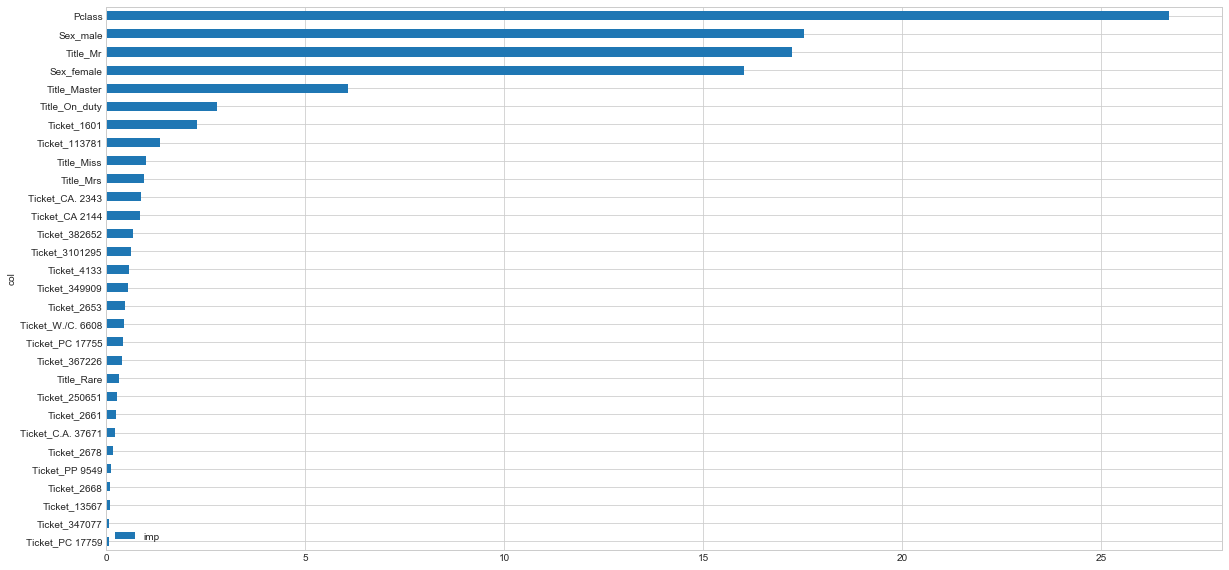

In [132]:
feature_importance(catboost_model,X_train)

In [133]:
# Precision and recall
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.7963185247707869
Recall: 0.7325877192982456
F1: 0.761904543652073
AUC: 0.8801651008212699


##################################################################################################################################################################################
# End Result Analysis
##################################################################################################################################################################################

In [134]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test_ready)

In [135]:
# See if it has worked
predictions[:20]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
      dtype=int64)

In [136]:
len(test_ready.dtypes)

124

In [138]:
submission = pd.DataFrame()
submission['PassengerId'] = df_test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset

# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

# How does our submission dataframe look?
submission.head(7)


# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
    submission.to_csv('sense_and_the_power_of_align_simple.csv', index=False)
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Converted Survived column to integers.
Submission dataframe is the same length as test (418 rows).
